# 1 пункт 

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import nltk
import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords
from pymorphy2 import MorphAnalyzer
from nltk.tokenize import word_tokenize
from torch.optim.lr_scheduler import ReduceLROnPlateau, LinearLR
from gensim.models import Word2Vec
from sklearn.feature_extraction.text import TfidfVectorizer
from transformers import DistilBertModel
from transformers import DistilBertTokenizer
import transformers


In [3]:
#pip install transformers
#%pip uninstall torch transformers
#%pip install torch==2.0.0 transformers==4.41.2
#pip install hf_xet

In [4]:
sfera = pd.read_csv('train.csv')
print(sfera.head())

   id  ...                                   labels
0   0  ...  1 0 0 0 1 0 0 0 1 0 0 0 1 1 1 1 1 0 0 1
1   1  ...  0 0 0 1 0 0 0 0 1 0 0 0 1 1 0 1 1 0 0 1
2   2  ...  0 0 0 0 1 0 0 0 0 0 0 0 1 1 0 1 1 0 0 1
3   3  ...  1 1 0 0 1 0 0 1 1 1 1 1 1 1 1 0 0 1 1 0
4   4  ...  1 1 0 0 0 0 0 1 1 0 0 1 1 1 1 0 1 1 1 0

[5 rows x 3 columns]


In [5]:
sfera

,id,text,labels
0,0,15 января\nДетская развлекательная программа\n...,1 0 0 0 1 0 0 0 1 0 0 0 1 1 1 1 1 0 0 1
1,1,13 и 14 августа\nВыходные в Меге\nhttps://t.me...,0 0 0 1 0 0 0 0 1 0 0 0 1 1 0 1 1 0 0 1
2,2,Йокнапатофа\nПостановка Театр им. Маяковского\...,0 0 0 0 1 0 0 0 0 0 0 0 1 1 0 1 1 0 0 1
3,3,Впервые в Уфе танцевальная терапия в группе с ...,1 1 0 0 1 0 0 1 1 1 1 1 1 1 1 0 0 1 1 0
4,4,"🎹\nGRAND PIANO COMPETITION\n🎹\nДрузья, сегодня...",1 1 0 0 0 0 0 1 1 0 0 1 1 1 1 0 1 1 1 0
...,...,...,...
29563,29563,Выступление Симфо-группы TEODOR\n⠀\n22 июля в ...,0 0 0 0 0 0 0 1 1 0 0 0 0 1 0 1 1 1 1 0
29564,29564,"🔤\nЮЗИКЛ ""МОНТЕ-КРИСТО"" ТЕАТР ОПЕРЕТТЫ\nЭто оч...",1 1 1 0 0 0 0 1 0 1 1 1 0 1 1 0 1 1 1 0
29565,29565,РАСПИСАНИЕ БЕСПЛАТНЫХ ЭКСКУРСИЙ\nв октябре 202...,1 1 0 0 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 0
29566,29566,Долгожданный концерт Надежды Кадышевой в Рязан...,1 0 1 0 0 0 0 1 0 1 1 1 0 1 1 0 0 1 1 0


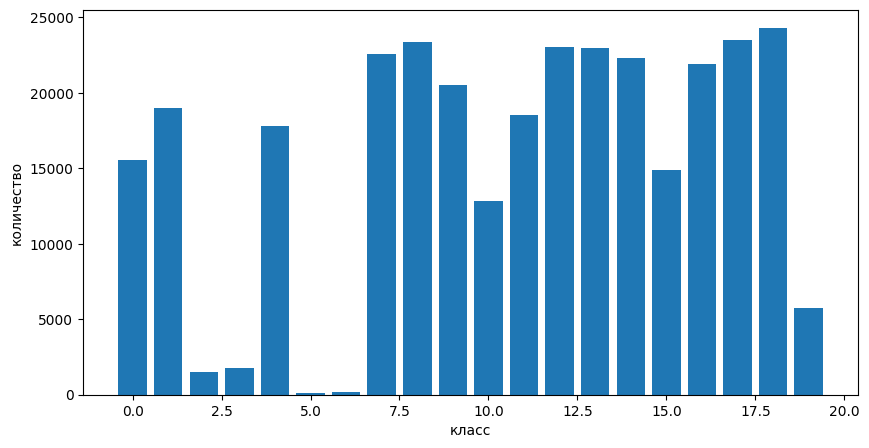

In [6]:
lab = sfera["labels"].str.split(" ", expand=True).astype(int)
count = lab.sum(axis=0) 

plt.figure(figsize=(10, 5))
plt.bar(range(20), count)
plt.xlabel("класс")
plt.ylabel("количество")
plt.show()

In [7]:
sfera["len_txt"] = sfera["text"].apply(len)
print(sfera["len_txt"].describe())

count    29568.000000
mean       604.812331
std        380.114437
min          1.000000
25%        306.000000
50%        592.000000
75%        850.000000
max       4081.000000
Name: len_txt, dtype: float64


In [8]:
for i in [1, 3, 7, 14, 17]:  # Пример нескольких классов
    print(f"\nкласс {i}:")
    text = sfera[lab[i] == 1]["text"].sample(2)
    for txt in text:
        print(i)
        print(txt[:300])  


класс 1:
1
Спектакль Один день из смерти Вадика Беляева...
25 МАЯ Театр "Квартет И" в помещении ДК им. Зуева МОСКВА НАЧАЛО В 19:00
У многих из нас есть тот самый ОЧЕНЬ БОГАТЫЙ ДРУГ. Недосягаемо богатый. Часто это интересный яркий человек, с которым связано много таких же интересных и ярких историй.Он родился и
1
Комедия «Подыскиваю жену, недорого!»
🏛
ДК им. Зуева
🗓️
09.06 (вс) в 19:00
🗓️
23.06 (вс) в 19:00
🏛
Театриум на Серпуховке
🗓️
16.06 (вс) в 19:00
🎫
Билеты по ссылке здесь
💚
-25% по промокоду ТИК
В ролях: Екатерина Скулкина/Надежда Ангарская, Мария Кравченко/Татьяна Морозова, Роман Юнусов/Роман Богданов

класс 3:
3
3-9 апреля
Афиша «Йәшлек House | Дом молодёжи Башкортостана»
Просмотр кино бесплатно
❗️
https://vk.com/yeshlekhouse
Пушкина 86
3
28 мая
Стэнд ап
с 19-00 Бесплатно
❗️
https://t.me/ufa_arteria
МЦ «Артерия», пр. Октября 67/2

класс 7:
7
Концерт группы «Аттракцион Воронова»
Когда: 22 сентября, 20:30
Где: Бар «Escobar», м. Площадь Ильича, ул. С. Радонежского, дом 15-17с17
#к

1) по графику с распредлением классов можно заметить что датасет несбалансированный,в классах (5 , 6, 20) практически нет данных , в 3 и 4 классах меньше 3000 данных, а в оставшихя от 5000 до 25000 тысяч данных
2) в данных имеются смайлики и другие символы ( наподобие @)
3) есть совсем короткие сообщения в несколько символов так и сообщения в несколько абзацев 

## 2 и 3 пункт ( они у меня вместе для удобства) 

# !!!1 модель!!! она же лучшая я ее в конец поставила чтобы два раза одно и тоже не дублировать

# 2 model w2v 

In [9]:
sfera = pd.read_csv('train.csv')
print(sfera.head())

   id  ...                                   labels
0   0  ...  1 0 0 0 1 0 0 0 1 0 0 0 1 1 1 1 1 0 0 1
1   1  ...  0 0 0 1 0 0 0 0 1 0 0 0 1 1 0 1 1 0 0 1
2   2  ...  0 0 0 0 1 0 0 0 0 0 0 0 1 1 0 1 1 0 0 1
3   3  ...  1 1 0 0 1 0 0 1 1 1 1 1 1 1 1 0 0 1 1 0
4   4  ...  1 1 0 0 0 0 0 1 1 0 0 1 1 1 1 0 1 1 1 0

[5 rows x 3 columns]


In [10]:
def tfidf_obrabotka(txt):
    txt = txt.lower()
    txt = re.sub(r'\n', ' ', txt)
    txt = re.sub(r'http\S+|www\S+|https\S+', '', txt)
    txt = re.sub(r'@\w+', '', txt)
    txt = re.sub(r'#\w+', '', txt)
    txt = re.sub(r'[\U0001F600-\U0001F64F\U0001F300-\U0001F5FF\U0001F680-\U0001F6FF\U0001F700-\U0001F77F\U0001F780-\U0001F7FF\U0001F800-\U0001F8FF\U0001F900-\U0001F9FF\U0001FA00-\U0001FA6F\U0001FA70-\U0001FAFF\U00002700-\U000027BF]', '', txt)
    txt = re.sub(r'\d+', ' <NUM> ', txt)
    txt = re.sub(r'\b(?:пн|вт|ср|чт|пт|сб|вс)\b', ' <DAY> ', txt, flags=re.IGNORECASE)# Удаление специальных символов
    txt = re.sub(r'[^\w\s]', ' ', txt)
    txt = re.sub(r'\s+', ' ', txt).strip()
    tok = word_tokenize(txt)
    tok = [morph.parse(token)[0].normal_form for token in tok if token not in stop_words]
    return tok  

In [11]:
def number(lbl_str):
    num = [int(x) for x in lbl_str.split()]
    return ' '.join(map(str, num))

def token_tok(tok):
    return tok


class Textic(Dataset):
    def __init__(self, texts, labels, w2v_model, max_len=50):
        self.texts = texts
        self.labels = labels
        self.w2v_model = w2v_model
        self.max_len = max_len
        self.vector_size = w2v_model.vector_size

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        tok = self.texts[idx]
        embeddings = np.zeros((self.max_len, self.vector_size))
        for i, word in enumerate(tok[:self.max_len]):
            if word in self.w2v_model.wv:
                embeddings[i] = self.w2v_model.wv[word]
        return {
            'text': torch.tensor(embeddings, dtype=torch.float32),
            'labels': torch.tensor([int(x) for x in self.labels[idx].split()], dtype=torch.float32)
        }

class modelka_Tfidf(nn.Module):
    def __init__(self, input_dim):
        super(modelka_Tfidf, self).__init__()
        self.lstm = nn.LSTM(input_dim, 64, batch_first=True)
        self.fc = nn.Linear(64, 20)  # 20 меток
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        x, _ = self.lstm(x)
        x = x[:, -1, :] 
        x = self.dropout(x)
        x = self.fc(x)
        return x


In [14]:
nltk.download('punkt')
nltk.download('stopwords')

stop_words = set(stopwords.words('russian'))
morph = MorphAnalyzer()


sfera['text_tfidf'] = sfera['text'].apply(tfidf_obrabotka)
sfera['labels'] = sfera['labels'].apply(number)


[nltk_data] Downloading package punkt to /home/jupyter/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/jupyter/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Эпоха 1
Лоси на трейне: 0.3447
F1 на трейне: 0.6871
Лоси на валидации: 0.2993
F1 на валидации: 0.7204
****************************************
Эпоха 2
Лоси на трейне: 0.2949
F1 на трейне: 0.7179
Лоси на валидации: 0.2752
F1 на валидации: 0.7329
****************************************
Эпоха 3
Лоси на трейне: 0.2778
F1 на трейне: 0.7285
Лоси на валидации: 0.2632
F1 на валидации: 0.7367
****************************************
Эпоха 4
Лоси на трейне: 0.2656
F1 на трейне: 0.7377
Лоси на валидации: 0.2537
F1 на валидации: 0.7363
****************************************
Эпоха 5
Лоси на трейне: 0.2580
F1 на трейне: 0.7468
Лоси на валидации: 0.2489
F1 на валидации: 0.7451
****************************************
Эпоха 6
Лоси на трейне: 0.2526
F1 на трейне: 0.7504
Лоси на валидации: 0.2445
F1 на валидации: 0.7478
****************************************
Эпоха 7
Лоси на трейне: 0.2473
F1 на трейне: 0.7566
Лоси на валидации: 0.2426
F1 на валидации: 0.7561
****************************************

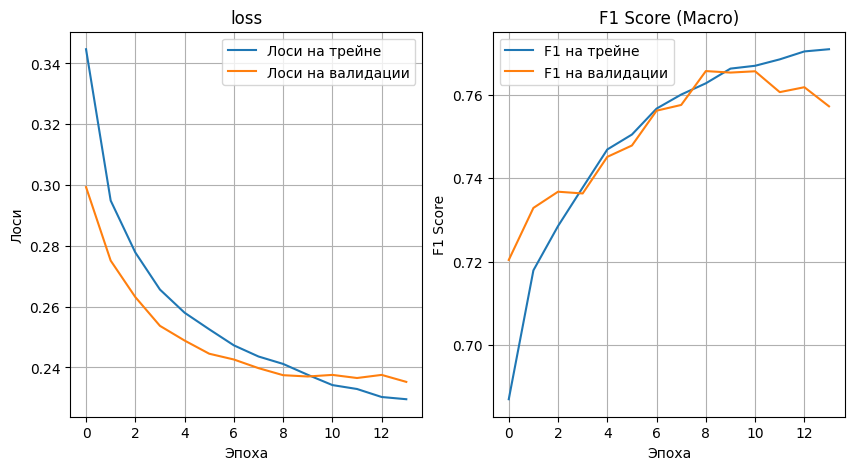

In [15]:
train_data, val_data = train_test_split(sfera, test_size=0.2, random_state=42)

train_texts = [text for text in train_data['text_tfidf']]
w2v_model = Word2Vec(sentences=train_texts, vector_size=100, window=5, min_count=1, workers=4)
w2v_model.save('w2v_model.pt')


train_dataset = Textic(train_data['text_tfidf'].values, train_data['labels'].values, w2v_model)
val_dataset = Textic(val_data['text_tfidf'].values, val_data['labels'].values, w2v_model)

train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=2)


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
modelka = modelka_Tfidf(input_dim=100).to(device)  
crit = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(modelka.parameters(), lr=0.001)
sched = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5)
warm_sched = LinearLR(optimizer, start_factor=0.1, end_factor=1.0, total_iters=len(train_loader)*2)

# Обучение модели
count_pati = 0
valid_f1_best = 0.0
val_loss_es = []
val_f1_mods = []
train_loss_es = []
train_f1_mods = []

for epoch in range(15):
    modelka.train()
    train_preds = []
    train_lab = []
    train_loss = 0
    for i in train_loader:
        optimizer.zero_grad()
        inp = i['text'].to(device)
        lab = i['labels'].to(device)
        outp = modelka(inp)
        loss = crit(outp, lab)
        loss.backward()
        optimizer.step()
        if epoch < 5:
            warm_sched.step()

        train_loss += loss.item()
        predicted = (outp > 0).float()
        train_preds.extend(predicted.cpu().numpy())
        train_lab.extend(lab.cpu().numpy())

    train_loss /= len(train_loader)
    train_f1 = f1_score(train_lab, train_preds, average='macro')
    train_loss_es.append(train_loss)
    train_f1_mods.append(train_f1)

    modelka.eval()
    val_preds = []
    val_lab = []
    val_loss = 0
    with torch.no_grad():
        for i in val_loader:
            inp = i['text'].to(device)
            lab = i['labels'].to(device)
            outp = modelka(inp)
            loss = crit(outp, lab)
            val_loss += loss.item()
            predicted = (outp > 0).float()
            val_preds.extend(predicted.cpu().numpy())
            val_lab.extend(lab.cpu().numpy())

    val_loss /= len(val_loader)
    val_f1 = f1_score(val_lab, val_preds, average='macro')
    val_loss_es.append(val_loss)
    val_f1_mods.append(val_f1)

    print(f'Эпоха {epoch+1}')
    print(f'Лоси на трейне: {train_loss:.4f}')
    print(f'F1 на трейне: {train_f1:.4f}')
    print(f'Лоси на валидации: {val_loss:.4f}')
    print(f'F1 на валидации: {val_f1:.4f}')
    print('****************************************')

    if val_f1 > valid_f1_best:
        valid_f1_best = val_f1
        torch.save(modelka.state_dict(), '1-best_w2v.pt')
        count_pati = 0
    else:
        count_pati += 1

    sched.step(-val_f1)

    if count_pati >= 5:
        print("stop")
        break

# Построение графиков
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_loss_es, label='Лоси на трейне')
plt.plot(val_loss_es, label='Лоси на валидации')
plt.title('loss')
plt.xlabel('Эпоха')
plt.ylabel('Лоси')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(train_f1_mods, label='F1 на трейне')
plt.plot(val_f1_mods, label='F1 на валидации')
plt.title('F1 Score (Macro)')
plt.xlabel('Эпоха')
plt.ylabel('F1 Score')
plt.legend()
plt.grid(True)
plt.show()

plt.close()

# 3 model

In [16]:
sfera = pd.read_csv('train.csv')
print(sfera.head())

   id  ...                                   labels
0   0  ...  1 0 0 0 1 0 0 0 1 0 0 0 1 1 1 1 1 0 0 1
1   1  ...  0 0 0 1 0 0 0 0 1 0 0 0 1 1 0 1 1 0 0 1
2   2  ...  0 0 0 0 1 0 0 0 0 0 0 0 1 1 0 1 1 0 0 1
3   3  ...  1 1 0 0 1 0 0 1 1 1 1 1 1 1 1 0 0 1 1 0
4   4  ...  1 1 0 0 0 0 0 1 1 0 0 1 1 1 1 0 1 1 1 0

[5 rows x 3 columns]


In [17]:
def cnn_obrabotka(txt):
    txt = re.sub(r'\n', ' ', txt)
    txt = re.sub(r'http\S+|www\S+|https\S+', '', txt)
    txt = re.sub(r'@\w+', '', txt)
    txt = re.sub(r'#\w+', '', txt)
    txt = re.sub(r'[\U0001F600-\U0001F64F\U0001F300-\U0001F5FF\U0001F680-\U0001F6FF\U0001F700-\U0001F77F\U0001F780-\U0001F7FF\U0001F800-\U0001F8FF\U0001F900-\U0001F9FF\U0001FA00-\U0001FA6F\U0001FA70-\U0001FAFF\U00002700-\U000027BF]', '', txt)
    txt = re.sub(r'\d+:\d+', '<TIME>', txt)
    txt = re.sub(r'\d+\s+(?:января|февраля|марта|апреля|мая|июня|июля|августа|сентября|октября|ноября|декабря)', '<DATE>', txt)
    txt = re.sub(r'[^\w\s]', ' ', txt)
    txt = re.sub(r'\s+', ' ', txt).strip()
    txt = txt.lower()
    tok = word_tokenize(txt)
    tok = [t for t in tok if len(t) >= 2]
    return tok


In [18]:
def number(lbl_str):
    num = [int(x) for x in lbl_str.split()]
    return ' '.join(map(str, num))

class modelka_CNN(nn.Module):
    def __init__(self, vocab_size, embed_dim=100, num_filters=64, kernel_sizes=[3, 4, 5], output_dim=20):
        super(modelka_CNN, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.convs = nn.ModuleList([
            nn.Conv1d(embed_dim, num_filters, kernel_size=k, padding=k//2) for k in kernel_sizes
        ])
        self.fc = nn.Linear(len(kernel_sizes) * num_filters, output_dim)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        x = self.embedding(x)  # [batch_size, max_len, embed_dim]
        x = x.permute(0, 2, 1)  # [batch_size, embed_dim, max_len]
        conv_outs = [self.relu(conv(x)) for conv in self.convs]  # Применяем свёртки
        pooled = [torch.max(out, dim=2)[0] for out in conv_outs]  # Max pooling
        x = torch.cat(pooled, dim=1)  # Конкатенация
        x = self.dropout(x)
        x = self.fc(x)
        return x
    
class Vocab:
    def __init__(self, texts, min_freq=1):
        word_freq = {}
        for text in texts:
            for word in text:
                word_freq[word] = word_freq.get(word, 0) + 1
        
        self.word2idx = {'<PAD>': 0, '<UNK>': 1}
        idx = 2
        for word, freq in word_freq.items():
            if freq >= min_freq:
                self.word2idx[word] = idx
                idx += 1
        self.idx2word = {idx: word for word, idx in self.word2idx.items()}
        self.vocab_size = len(self.word2idx)

    def text_to_indices(self, text, max_len=50):
        indices = [self.word2idx.get(word, self.word2idx['<UNK>']) for word in text[:max_len]]
        indices += [self.word2idx['<PAD>']] * (max_len - len(indices))
        return indices

class Textic(Dataset):
    def __init__(self, texts, labels, vocab, max_len=50):
        self.texts = texts
        self.labels = labels
        self.vocab = vocab
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        indices = self.vocab.text_to_indices(text, self.max_len)
        return {
            'text': torch.tensor(indices, dtype=torch.long),
            'labels': torch.tensor([int(x) for x in self.labels[idx].split()], dtype=torch.float32)
        }





[nltk_data] Downloading package punkt to /home/jupyter/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Эпоха 1
Лоси на трейне: 0.3849
F1 на трейне: 0.6633
Лоси на валидации: 0.3058
F1 на валидации: 0.7180
****************************************
Эпоха 2
Лоси на трейне: 0.3222
F1 на трейне: 0.7131
Лоси на валидации: 0.2909
F1 на валидации: 0.7438
****************************************
Эпоха 3
Лоси на трейне: 0.2954
F1 на трейне: 0.7375
Лоси на валидации: 0.2700
F1 на валидации: 0.7379
****************************************
Эпоха 4
Лоси на трейне: 0.2627
F1 на трейне: 0.7614
Лоси на валидации: 0.2647
F1 на валидации: 0.7590
****************************************
Эпоха 5
Лоси на трейне: 0.2365
F1 на трейне: 0.7915
Лоси на валидации: 0.2651
F1 на валидации: 0.7633
****************************************
Эпоха 6
Лоси на трейне: 0.2125
F1 на трейне: 0.8075
Лоси на валидации: 0.2669
F1 на валидации: 0.7686
****************************************
Эпоха 7
Лоси на трейне: 0.1938
F1 на трейне: 0.8239
Лоси на валидации: 0.2734
F1 на валидации: 0.7984
****************************************

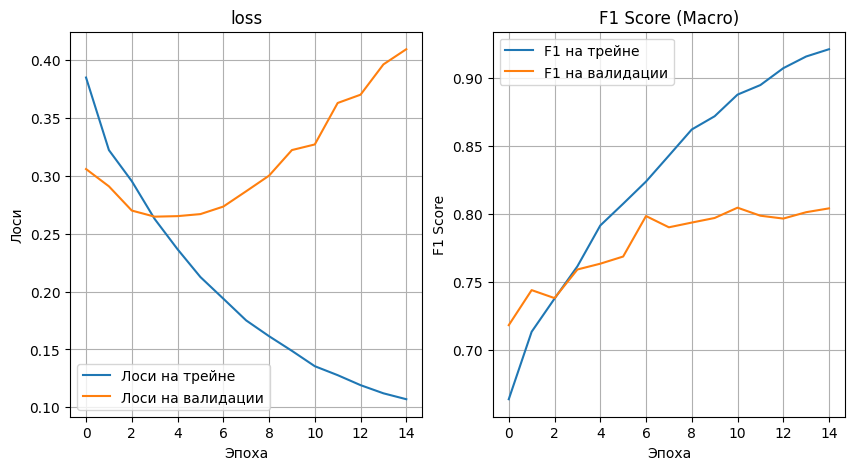

In [19]:
nltk.download('punkt')
sfera['text_tfidf'] = sfera['text'].apply(cnn_obrabotka)
sfera['labels'] = sfera['labels'].apply(number)


train_data, val_data = train_test_split(sfera, test_size=0.2, random_state=42)
vocab = Vocab(train_data['text_tfidf'].values)

train_dataset = Textic(train_data['text_tfidf'].values, train_data['labels'].values, vocab)
val_dataset = Textic(val_data['text_tfidf'].values, val_data['labels'].values, vocab)
train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=2)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
modelka = modelka_CNN(vocab_size=vocab.vocab_size, embed_dim=100).to(device)
crit = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(modelka.parameters(), lr=0.001)
sched = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5)
warm_sched = LinearLR(optimizer, start_factor=0.1, end_factor=1.0, total_iters=len(train_loader)*2)

count_pati = 0
valid_f1_best = 0.0
val_loss_es = []
val_f1_mods = []
train_loss_es = []
train_f1_mods = []

for epoch in range(15):
    modelka.train()
    train_preds = []
    train_lab = []
    train_loss = 0
    for i in train_loader:
        optimizer.zero_grad()
        inp = i['text'].to(device)
        lab = i['labels'].to(device)
        outp = modelka(inp)
        loss = crit(outp, lab)
        loss.backward()
        optimizer.step()
        if epoch < 5:
            warm_sched.step()

        train_loss += loss.item()
        predicted = (outp > 0).float()
        train_preds.extend(predicted.cpu().numpy())
        train_lab.extend(lab.cpu().numpy())

    train_loss /= len(train_loader)
    train_f1 = f1_score(train_lab, train_preds, average='macro')
    train_loss_es.append(train_loss)
    train_f1_mods.append(train_f1)

    modelka.eval()
    val_preds = []
    val_lab = []
    val_loss = 0
    with torch.no_grad():
        for i in val_loader:
            inp = i['text'].to(device)
            lab = i['labels'].to(device)
            outp = modelka(inp)
            loss = crit(outp, lab)
            val_loss += loss.item()
            predicted = (outp > 0).float()
            val_preds.extend(predicted.cpu().numpy())
            val_lab.extend(lab.cpu().numpy())

    val_loss /= len(val_loader)
    val_f1 = f1_score(val_lab, val_preds, average='macro')
    val_loss_es.append(val_loss)
    val_f1_mods.append(val_f1)

    print(f'Эпоха {epoch+1}')
    print(f'Лоси на трейне: {train_loss:.4f}')
    print(f'F1 на трейне: {train_f1:.4f}')
    print(f'Лоси на валидации: {val_loss:.4f}')
    print(f'F1 на валидации: {val_f1:.4f}')
    print('****************************************')

    if val_f1 > valid_f1_best:
        valid_f1_best = val_f1
        torch.save(modelka.state_dict(), '1-best_cnn.pt')
        count_pati = 0
    else:
        count_pati += 1

    sched.step(-val_f1)

    if count_pati >= 5:
        print("stop")
        break

# Построение графиков
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_loss_es, label='Лоси на трейне')
plt.plot(val_loss_es, label='Лоси на валидации')
plt.title('loss')
plt.xlabel('Эпоха')
plt.ylabel('Лоси')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(train_f1_mods, label='F1 на трейне')
plt.plot(val_f1_mods, label='F1 на валидации')
plt.title('F1 Score (Macro)')
plt.xlabel('Эпоха')
plt.ylabel('F1 Score')
plt.legend()
plt.grid(True)
plt.show()

plt.close()



# 4 model



In [20]:
def rnn_obrabotka(txt):
    txt = re.sub(r'\n', ' ', txt)
    txt = re.sub(r'http\S+|www\S+|https\S+', '', txt)
    txt = re.sub(r'@\w+', '', txt)
    txt = re.sub(r'#\w+', '', txt)
    txt = re.sub(r'[\U0001F600-\U0001F64F\U0001F300-\U0001F5FF\U0001F680-\U0001F6FF\U0001F700-\U0001F77F\U0001F780-\U0001F7FF\U0001F800-\U0001F8FF\U0001F900-\U0001F9FF\U0001FA00-\U0001FA6F\U0001FA70-\U0001FAFF\U00002700-\U000027BF]', '', txt)
    txt = re.sub(r'\d+:\d+', '<TIME>', txt)
    txt = re.sub(r'\d+\s+(?:января|февраля|марта|апреля|мая|июня|июля|августа|сентября|октября|ноября|декабря)', '<DATE>', txt)
    txt = re.sub(r'[^\w\s]', ' ', txt)
    txt = re.sub(r'\s+', ' ', txt).strip()
    txt = txt.lower()
    tok = word_tokenize(txt)
    tok = [t for t in tok if len(t) >= 2]
    return tok

In [21]:
def number(lbl_str):
    num = [int(x) for x in lbl_str.split()]
    return ' '.join(map(str, num))

class Vocab:
    def __init__(self, texts, min_freq=1):
        word_freq = {}
        for text in texts:
            for word in text:
                word_freq[word] = word_freq.get(word, 0) + 1

        self.word2idx = {'<PAD>': 0, '<UNK>': 1}
        idx = 2
        for word, freq in word_freq.items():
            if freq >= min_freq:
                self.word2idx[word] = idx
                idx += 1
        self.idx2word = {idx: word for word, idx in self.word2idx.items()}
        self.vocab_size = len(self.word2idx)

    def text_to_indices(self, text, max_len=50):
        indices = [self.word2idx.get(word, self.word2idx['<UNK>']) for word in text[:max_len]]
        indices += [self.word2idx['<PAD>']] * (max_len - len(indices))
        return indices
    
class modelka_RNN(nn.Module):
    def __init__(self, vocab_size, embed_dim=100, hidden_dim=64, output_dim=20):
        super(modelka_RNN, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        x = self.embedding(x)  
        x, _ = self.lstm(x)   
        x = x[:, -1, :]        
        x = self.dropout(x)
        x = self.fc(x)
        return x

class Textic(Dataset):
    def __init__(self, texts, labels, vocab, max_len=50):
        self.texts = texts
        self.labels = labels
        self.vocab = vocab
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        indices = self.vocab.text_to_indices(text, self.max_len)
        return {
            'text': torch.tensor(indices, dtype=torch.long),
            'labels': torch.tensor([int(x) for x in self.labels[idx].split()], dtype=torch.float32)
        }


[nltk_data] Downloading package punkt to /home/jupyter/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Эпоха 1
Лоси на трейне: 0.3851
F1 на трейне: 0.6625
Лоси на валидации: 0.3371
F1 на валидации: 0.6811
****************************************
Эпоха 2
Лоси на трейне: 0.3117
F1 на трейне: 0.7069
Лоси на валидации: 0.2853
F1 на валидации: 0.7310
****************************************
Эпоха 3
Лоси на трейне: 0.2678
F1 на трейне: 0.7328
Лоси на валидации: 0.2631
F1 на валидации: 0.7370
****************************************
Эпоха 4
Лоси на трейне: 0.2339
F1 на трейне: 0.7548
Лоси на валидации: 0.2510
F1 на валидации: 0.7471
****************************************
Эпоха 5
Лоси на трейне: 0.2072
F1 на трейне: 0.7721
Лоси на валидации: 0.2498
F1 на валидации: 0.7560
****************************************
Эпоха 6
Лоси на трейне: 0.1868
F1 на трейне: 0.7917
Лоси на валидации: 0.2513
F1 на валидации: 0.7582
****************************************
Эпоха 7
Лоси на трейне: 0.1691
F1 на трейне: 0.8034
Лоси на валидации: 0.2558
F1 на валидации: 0.7575
****************************************

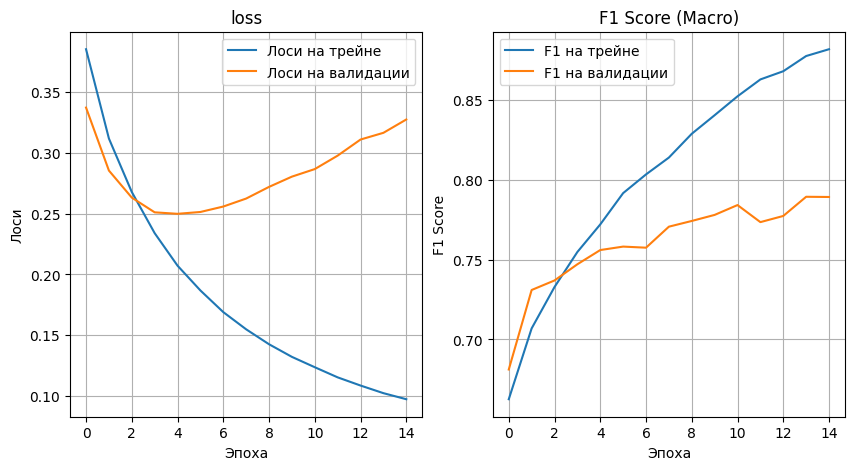

In [22]:
nltk.download('punkt')
sfera['text_tfidf'] = sfera['text'].apply(rnn_obrabotka)
sfera['labels'] = sfera['labels'].apply(number)

train_data, val_data = train_test_split(sfera, test_size=0.2, random_state=42)
vocab = Vocab(train_data['text_tfidf'].values)

train_dataset = Textic(train_data['text_tfidf'].values, train_data['labels'].values, vocab)
val_dataset = Textic(val_data['text_tfidf'].values, val_data['labels'].values, vocab)

train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=2)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
modelka = modelka_RNN(vocab_size=vocab.vocab_size, embed_dim=100).to(device)
crit = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(modelka.parameters(), lr=0.001)
sched = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3)
warm_sched = LinearLR(optimizer, start_factor=0.1, end_factor=1.0, total_iters=len(train_loader)*2)

count_pati = 0
valid_f1_best = 0.0
val_loss_es = []
val_f1_mods = []
train_loss_es = []
train_f1_mods = []

for epoch in range(15):
    modelka.train()
    train_preds = []
    train_lab = []
    train_loss = 0
    for i in train_loader:
        optimizer.zero_grad()
        inp = i['text'].to(device)
        lab = i['labels'].to(device)
        outp = modelka(inp)
        loss = crit(outp, lab)
        loss.backward()
        optimizer.step()
        if epoch < 5:
            warm_sched.step()

        train_loss += loss.item()
        predicted = (outp > 0).float()
        train_preds.extend(predicted.cpu().numpy())
        train_lab.extend(lab.cpu().numpy())

    train_loss /= len(train_loader)
    train_f1 = f1_score(train_lab, train_preds, average='macro')
    train_loss_es.append(train_loss)
    train_f1_mods.append(train_f1)

    modelka.eval()
    val_preds = []
    val_lab = []
    val_loss = 0
    with torch.no_grad():
        for i in val_loader:
            inp = i['text'].to(device)
            lab = i['labels'].to(device)
            outp = modelka(inp)
            loss = crit(outp, lab)
            val_loss += loss.item()
            predicted = (outp > 0).float()
            val_preds.extend(predicted.cpu().numpy())
            val_lab.extend(lab.cpu().numpy())

    val_loss /= len(val_loader)
    val_f1 = f1_score(val_lab, val_preds, average='macro')
    val_loss_es.append(val_loss)
    val_f1_mods.append(val_f1)

    print(f'Эпоха {epoch+1}')
    print(f'Лоси на трейне: {train_loss:.4f}')
    print(f'F1 на трейне: {train_f1:.4f}')
    print(f'Лоси на валидации: {val_loss:.4f}')
    print(f'F1 на валидации: {val_f1:.4f}')
    print('****************************************')

    if val_f1 > valid_f1_best:
        valid_f1_best = val_f1
        torch.save(modelka.state_dict(), '1-best_rnn.pt')
        count_pati = 0
    else:
        count_pati += 1

    sched.step(-val_f1)

    if count_pati >= 3:
        print("stop")
        break

# Построение графиков
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_loss_es, label='Лоси на трейне')
plt.plot(val_loss_es, label='Лоси на валидации')
plt.title('loss')
plt.xlabel('Эпоха')
plt.ylabel('Лоси')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(train_f1_mods, label='F1 на трейне')
plt.plot(val_f1_mods, label='F1 на валидации')
plt.title('F1 Score (Macro)')
plt.xlabel('Эпоха')
plt.ylabel('F1 Score')
plt.legend()
plt.grid(True)
plt.show()

plt.close()

5 model

In [2]:
sfera = pd.read_csv('train.csv')
print(sfera.head())

   id  ...                                   labels
0   0  ...  1 0 0 0 1 0 0 0 1 0 0 0 1 1 1 1 1 0 0 1
1   1  ...  0 0 0 1 0 0 0 0 1 0 0 0 1 1 0 1 1 0 0 1
2   2  ...  0 0 0 0 1 0 0 0 0 0 0 0 1 1 0 1 1 0 0 1
3   3  ...  1 1 0 0 1 0 0 1 1 1 1 1 1 1 1 0 0 1 1 0
4   4  ...  1 1 0 0 0 0 0 1 1 0 0 1 1 1 1 0 1 1 1 0

[5 rows x 3 columns]


In [ ]:
def bert_obrabotka(txt):
    txt = re.sub(r'\n', ' ', txt)
    txt = re.sub(r'http\S+|www\S+|https\S+', '', txt)
    txt = re.sub(r'@\w+', '', txt)
    txt = re.sub(r'#\w+', '', txt)
    txt = re.sub(r'[\U0001F600-\U0001F64F\U0001F300-\U0001F5FF\U0001F680-\U0001F6FF\U0001F700-\U0001F77F\U0001F780-\U0001F7FF\U0001F800-\U0001F8FF\U0001F900-\U0001F9FF\U0001FA00-\U0001FA6F\U0001FA70-\U0001FAFF\U00002700-\U000027BF]', '', txt)
    txt = re.sub(r'[^\w\s.,!?-]', ' ', txt)
    txt = re.sub(r'\s+', ' ', txt).strip()
    return txt

In [ ]:
def number(lbl_str):
    num = [int(x) for x in lbl_str.split()]
    return ' '.join(map(str, num))


class modelka_BERT(nn.Module):
    def __init__(self, output_dim=20):
        super(modelka_BERT, self).__init__()
        self.bert = DistilBertModel.from_pretrained('distilbert-base-multilingual-cased')
        self.fc = nn.Linear(768, output_dim)  # DistilBERT output dim = 768
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.3)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        cls_output = outputs.last_hidden_state[:, 0, :]  # [CLS] token
        x = self.dropout(cls_output)
        x = self.fc(x)
        return x
    
class Textic(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        encoding = self.tokenizer(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor([int(x) for x in self.labels[idx].split()], dtype=torch.float32)
        }



In [3]:
sfera['text_cleaned'] = sfera['text'].apply(bert_obrabotka)
sfera['labels'] = sfera['labels'].apply(number)

Эпоха 1
Лоси на трейне: 0.3006
F1 на трейне: 0.7187
Лоси на валидации: 0.2340
F1 на валидации: 0.7543
****************************************
Эпоха 2
Лоси на трейне: 0.2144
F1 на трейне: 0.7692
Лоси на валидации: 0.1960
F1 на валидации: 0.7804
****************************************
Эпоха 3
Лоси на трейне: 0.1757
F1 на трейне: 0.8025
Лоси на валидации: 0.1810
F1 на валидации: 0.8019
****************************************
Эпоха 4
Лоси на трейне: 0.1430
F1 на трейне: 0.8317
Лоси на валидации: 0.1809
F1 на валидации: 0.8050
****************************************
Эпоха 5
Лоси на трейне: 0.1177
F1 на трейне: 0.8567
Лоси на валидации: 0.1796
F1 на валидации: 0.8233
****************************************
Эпоха 6
Лоси на трейне: 0.0984
F1 на трейне: 0.8694
Лоси на валидации: 0.1843
F1 на валидации: 0.8204
****************************************
Эпоха 7
Лоси на трейне: 0.0825
F1 на трейне: 0.8863
Лоси на валидации: 0.1997
F1 на валидации: 0.8291
****************************************

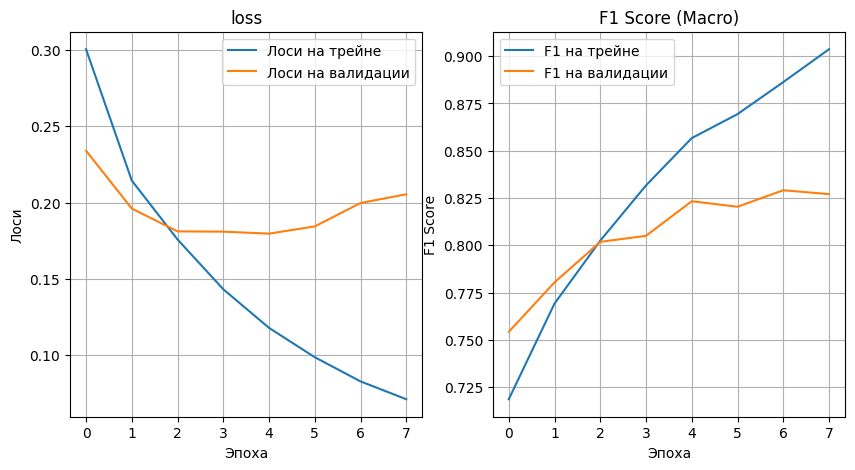

In [6]:
train_data, val_data = train_test_split(sfera, test_size=0.2, random_state=42)

tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-multilingual-cased')

train_dataset = Textic(train_data['text_cleaned'].values, train_data['labels'].values, tokenizer)
val_dataset = Textic(val_data['text_cleaned'].values, val_data['labels'].values, tokenizer)

train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=2)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
modelka = modelka_BERT().to(device)
crit = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(modelka.parameters(), lr=2e-5)  
sched = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10)
warm_sched = LinearLR(optimizer, start_factor=0.1, end_factor=1.0, total_iters=len(train_loader)*2)


count_pati = 0
valid_f1_best = 0.0
val_loss_es = []
val_f1_mods = []
train_loss_es = []
train_f1_mods = []

for epoch in range(8):  
    modelka.train()
    train_preds = []
    train_lab = []
    train_loss = 0
    for i in train_loader:
        optimizer.zero_grad()
        input_ids = i['input_ids'].to(device)
        attention_mask = i['attention_mask'].to(device)
        lab = i['labels'].to(device)
        outp = modelka(input_ids, attention_mask)
        loss = crit(outp, lab)
        loss.backward()
        optimizer.step()
        if epoch < 2: 
            warm_sched.step()

        train_loss += loss.item()
        predicted = (outp > 0).float()
        train_preds.extend(predicted.cpu().numpy())
        train_lab.extend(lab.cpu().numpy())

    train_loss /= len(train_loader)
    train_f1 = f1_score(train_lab, train_preds, average='macro')
    train_loss_es.append(train_loss)
    train_f1_mods.append(train_f1)

    modelka.eval()
    val_preds = []
    val_lab = []
    val_loss = 0
    with torch.no_grad():
        for i in val_loader:
            input_ids = i['input_ids'].to(device)
            attention_mask = i['attention_mask'].to(device)
            lab = i['labels'].to(device)
            outp = modelka(input_ids, attention_mask)
            loss = crit(outp, lab)
            val_loss += loss.item()
            predicted = (outp > 0).float()
            val_preds.extend(predicted.cpu().numpy())
            val_lab.extend(lab.cpu().numpy())

    val_loss /= len(val_loader)
    val_f1 = f1_score(val_lab, val_preds, average='macro')
    val_loss_es.append(val_loss)
    val_f1_mods.append(val_f1)

    print(f'Эпоха {epoch+1}')
    print(f'Лоси на трейне: {train_loss:.4f}')
    print(f'F1 на трейне: {train_f1:.4f}')
    print(f'Лоси на валидации: {val_loss:.4f}')
    print(f'F1 на валидации: {val_f1:.4f}')
    print('****************************************')

    if val_f1 > valid_f1_best:
        valid_f1_best = val_f1
        torch.save(modelka.state_dict(), '1-best_bert.pt')
        count_pati = 0
    else:
        count_pati += 1

    sched.step(-val_f1)

    if count_pati >= 5:  
        print("stop")
        break

# Построение графиков
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_loss_es, label='Лоси на трейне')
plt.plot(val_loss_es, label='Лоси на валидации')
plt.title('loss')
plt.xlabel('Эпоха')
plt.ylabel('Лоси')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(train_f1_mods, label='F1 на трейне')
plt.plot(val_f1_mods, label='F1 на валидации')
plt.title('F1 Score (Macro)')
plt.xlabel('Эпоха')
plt.ylabel('F1 Score')
plt.legend()
plt.grid(True)
plt.show()

plt.close()

## лучшая модель - 1 модель tfidf

In [24]:
sfera = pd.read_csv('train.csv')
print(sfera.head())

   id  ...                                   labels
0   0  ...  1 0 0 0 1 0 0 0 1 0 0 0 1 1 1 1 1 0 0 1
1   1  ...  0 0 0 1 0 0 0 0 1 0 0 0 1 1 0 1 1 0 0 1
2   2  ...  0 0 0 0 1 0 0 0 0 0 0 0 1 1 0 1 1 0 0 1
3   3  ...  1 1 0 0 1 0 0 1 1 1 1 1 1 1 1 0 0 1 1 0
4   4  ...  1 1 0 0 0 0 0 1 1 0 0 1 1 1 1 0 1 1 1 0

[5 rows x 3 columns]


In [25]:
sfera

,id,text,labels
0,0,15 января\nДетская развлекательная программа\n...,1 0 0 0 1 0 0 0 1 0 0 0 1 1 1 1 1 0 0 1
1,1,13 и 14 августа\nВыходные в Меге\nhttps://t.me...,0 0 0 1 0 0 0 0 1 0 0 0 1 1 0 1 1 0 0 1
2,2,Йокнапатофа\nПостановка Театр им. Маяковского\...,0 0 0 0 1 0 0 0 0 0 0 0 1 1 0 1 1 0 0 1
3,3,Впервые в Уфе танцевальная терапия в группе с ...,1 1 0 0 1 0 0 1 1 1 1 1 1 1 1 0 0 1 1 0
4,4,"🎹\nGRAND PIANO COMPETITION\n🎹\nДрузья, сегодня...",1 1 0 0 0 0 0 1 1 0 0 1 1 1 1 0 1 1 1 0
...,...,...,...
29563,29563,Выступление Симфо-группы TEODOR\n⠀\n22 июля в ...,0 0 0 0 0 0 0 1 1 0 0 0 0 1 0 1 1 1 1 0
29564,29564,"🔤\nЮЗИКЛ ""МОНТЕ-КРИСТО"" ТЕАТР ОПЕРЕТТЫ\nЭто оч...",1 1 1 0 0 0 0 1 0 1 1 1 0 1 1 0 1 1 1 0
29565,29565,РАСПИСАНИЕ БЕСПЛАТНЫХ ЭКСКУРСИЙ\nв октябре 202...,1 1 0 0 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 0
29566,29566,Долгожданный концерт Надежды Кадышевой в Рязан...,1 0 1 0 0 0 0 1 0 1 1 1 0 1 1 0 0 1 1 0


# очистка текста

In [26]:
def tfidf_obrabotka(txt):
    txt = txt.lower()
    txt = re.sub(r'http\S+|www\S+|https\S+', '', txt)
    txt = re.sub(r'(\d+):(\d+)', r'\1_\2', txt)
    tok = word_tokenize(txt)
    tok = [morph.parse(token)[0].normal_form for token in tok if token not in stop_words]
    return tok

In [27]:
class Textic(Dataset):
    def __init__(self, texts, labels):
        self.texts = texts
        self.labels = labels

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        return {
            'text': torch.tensor(self.texts[idx], dtype=torch.float32),
            'labels': torch.tensor([int(x) for x in self.labels[idx].split()], dtype=torch.float32)
        }

def number(lbl_str):
    num = [int(x) for x in lbl_str.split()]
    return ' '.join(map(str, num))

def token_tok(tok):
    return tok

class modelka_Tfidf(nn.Module):
    def __init__(self, input_dim):
        super(modelka_Tfidf, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 20) 
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x

[nltk_data] Downloading package punkt to /home/jupyter/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/jupyter/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Фактическое количество признаков после TF-IDF: 5000
Эпоха 1
Лоси на трейне: 0.4652
F1 на трейне: 0.6158
Лоси на валидации: 0.3300
F1 на валидации: 0.6887
****************************************
Эпоха 2
Лоси на трейне: 0.3081
F1 на трейне: 0.6938
Лоси на валидации: 0.2657
F1 на валидации: 0.7250
****************************************
Эпоха 3
Лоси на трейне: 0.2612
F1 на трейне: 0.7282
Лоси на валидации: 0.2401
F1 на валидации: 0.7414
****************************************
Эпоха 4
Лоси на трейне: 0.2370
F1 на трейне: 0.7448
Лоси на валидации: 0.2266
F1 на валидации: 0.7530
****************************************
Эпоха 5
Лоси на трейне: 0.2198
F1 на трейне: 0.7564
Лоси на валидации: 0.2176
F1 на валидации: 0.7563
****************************************
Эпоха 6
Лоси на трейне: 0.2059
F1 на трейне: 0.7702
Лоси на валидации: 0.2118
F1 на валидации: 0.7625
****************************************
Эпоха 7
Лоси на трейне: 0.1942
F1 на трейне: 0.7839
Лоси на валидации: 0.2077
F1 на валида

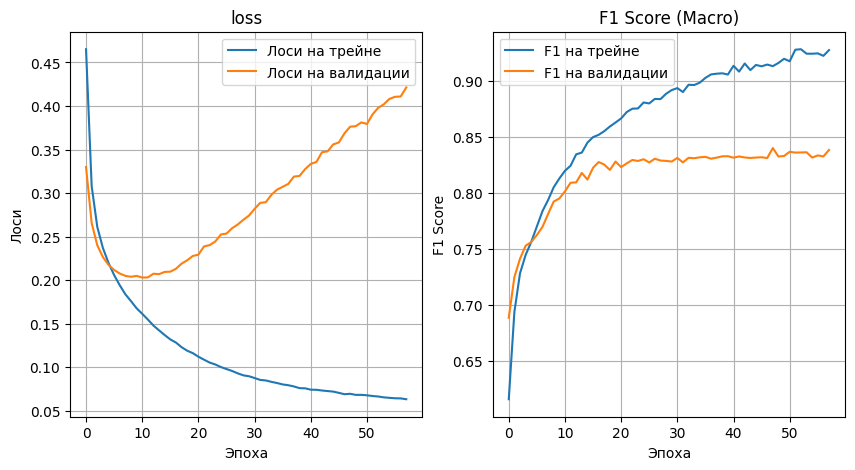

In [28]:
nltk.download('punkt')
nltk.download('stopwords')
stop_words = set(stopwords.words('russian'))
morph = MorphAnalyzer()

sfera['text_tfidf'] = sfera['text'].apply(tfidf_obrabotka)
sfera['labels'] = sfera['labels'].apply(number)
train_data, val_data = train_test_split(sfera, test_size=0.2, random_state=42)

vect = TfidfVectorizer(analyzer='word', tokenizer=token_tok, preprocessor=lambda x: x, lowercase=False, max_features=5000)
X_train_TFI = vect.fit_transform(train_data['text_tfidf']).toarray()
input_dim = X_train_TFI.shape[1] 
print(f"Фактическое количество признаков после TF-IDF: {input_dim}")

X_valid_TFI = vect.transform(val_data['text_tfidf']).toarray()

train_dataset = Textic(X_train_TFI, train_data['labels'].values)
val_dataset = Textic(X_valid_TFI, val_data['labels'].values)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32) 

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
modelka = modelka_Tfidf(input_dim=input_dim).to(device)
crit = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(modelka.parameters(), lr=0.001)
sched = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10)
warm_sched = LinearLR(optimizer, start_factor=0.1, end_factor=1.0, total_iters=len(train_loader)*2)

count_pati = 0
valid_f1_best = 0.0
val_loss_es=[]
val_f1_mods=[]
train_loss_es = []
train_f1_mods=[]

for epoch in range(100):
    modelka.train()
    train_preds= []
    train_lab = []
    train_loss=0
    for i in train_loader:
        optimizer.zero_grad()
        inp = i['text'].to(device)
        lab = i['labels'].to(device)
        outp = modelka(inp)
        loss = crit(outp, lab)
        loss.backward()
        optimizer.step()
        if epoch < 5:
            warm_sched.step()

        train_loss += loss.item()
        predicted = (outp > 0).float()
        train_preds.extend(predicted.cpu().numpy())
        train_lab.extend(lab.cpu().numpy())

    train_loss /= len(train_loader)
    train_f1 = f1_score(train_lab, train_preds, average='macro')
    train_loss_es.append(train_loss)
    train_f1_mods.append(train_f1)

    modelka.eval()
    val_preds=[]
    val_lab = []
    val_loss=0
    with torch.no_grad():
        for i in val_loader:
            inp = i['text'].to(device)
            lab = i['labels'].to(device)
            outp = modelka(inp)
            loss = crit(outp, lab)
            val_loss += loss.item()
            predicted = (outp > 0).float()
            val_preds.extend(predicted.cpu().numpy())
            val_lab.extend(lab.cpu().numpy())

    val_loss /= len(val_loader)
    val_f1 = f1_score(val_lab, val_preds, average='macro')
    val_loss_es.append(val_loss)
    val_f1_mods.append(val_f1)

    print(f'Эпоха {epoch+1}')
    print(f'Лоси на трейне: {train_loss:.4f}')
    print(f'F1 на трейне: {train_f1:.4f}')
    print(f'Лоси на валидации: {val_loss:.4f}')
    print(f'F1 на валидации: {val_f1:.4f}')
    print('****************************************')
    
    if val_f1 > valid_f1_best:
        valid_f1_best = val_f1
        torch.save(modelka.state_dict(), '1-best_tfidf.pt')
        count_pati = 0
    else:
        count_pati += 1

    sched.step(-val_f1)

    if count_pati >= 10:
        print("stop")
        break

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_loss_es, label='Лоси на трейне')
plt.plot(val_loss_es, label='Лоси на валидации')
plt.title('loss')
plt.xlabel('Эпоха')
plt.ylabel('Лоси')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(train_f1_mods, label='F1 на трейне')
plt.plot(val_f1_mods, label='F1 на валидации')
plt.title('F1 Score (Macro)')
plt.xlabel('Эпоха')
plt.ylabel('F1 Score')
plt.legend()
plt.grid(True)
plt.show()

plt.close()

In [29]:
testic = pd.read_csv('test.csv')
print(testic.head())
testic['text_tfidf'] = testic['text'].apply(tfidf_obrabotka)

      id                                               text
0  29568  ЭЙ, ВЛЮБЛЁННЫЕ\nСкидка 20% промокоду SYHOYZ\nн...
1  29569                                       Пруды Москвы
2  29570  🤪\n🤪\n👏\n👏\n😄\n😄\n👏\n👏\n👨‍👩‍👦\nСемейка лёгкого...
3  29571  24 СЕНТЯБРЯ\nИсторический фестиваль «Башкирия ...
4  29572  19-20 августа\nДетский клуб в кафе «Отдых»\nТе...


In [30]:
class TxtDat(Dataset):
    def __init__(self, texts, labels=None):
        self.texts = texts
        self.labels = labels

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        item = {'text': torch.tensor(self.texts[idx], dtype=torch.float32)}
        if self.labels is not None:
            item['labels'] = torch.tensor([int(x) for x in self.labels[idx].split()], dtype=torch.float32)
        return item

In [31]:
X_test_TFI = vect.transform(testic['text_tfidf']).toarray()
test_dataset = TxtDat(X_test_TFI)
test_loader = DataLoader(test_dataset, batch_size=2) 

modelka.load_state_dict(torch.load('1-best_tfidf.pt'))
modelka.eval()
test_preds = []

with torch.no_grad():
    for i in test_loader:
        inp = i['text'].to(device)
        outp = modelka(inp)
        predicted = (outp > 0).float()
        test_preds.extend(predicted.cpu().numpy())
        
labels = [' '.join(map(str, map(int, pred))) for pred in test_preds]

submission = pd.DataFrame({
    'id': testic['id'],
    'labels': labels
})

submission.to_csv('submission.csv', index=False)
print(pd.read_csv('submission.csv'))

         id                                   labels
0     29568  1 1 0 0 1 0 0 1 1 1 0 1 1 1 1 0 1 1 1 0
1     29569  1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 1 0 0 1
2     29570  0 1 0 0 1 0 0 1 0 1 0 0 1 1 1 0 1 1 1 0
3     29571  0 1 0 0 1 0 0 1 1 1 0 0 1 1 0 0 1 0 1 0
4     29572  0 0 0 0 1 0 0 0 1 0 0 0 1 1 1 1 1 0 0 1
...     ...                                      ...
7387  36955  0 1 0 0 1 0 0 1 1 1 1 1 1 0 1 0 1 1 1 0
7388  36956  1 1 0 0 1 0 0 1 1 0 1 1 1 1 1 0 0 1 1 0
7389  36957  0 1 0 0 1 0 0 1 1 0 0 1 1 1 1 0 1 1 1 0
7390  36958  1 1 0 0 1 0 0 1 1 1 1 1 1 0 1 0 1 1 1 0
7391  36959  1 1 0 0 1 0 0 1 1 1 1 1 1 1 1 1 0 1 1 0

[7392 rows x 2 columns]
